# Exercício Programa 2 - MAC0209 - Modelagem e Simulação 
## Grupo: Eduardo Nascimento, Gabriel Massukado, Larissa Goto, Nathalia Borin, Matheus Lima

## Introdução

Para o segundo projeto de MAC0209, tivemos que modelar e simular 3 situações físicas: um movimento bidimensional, um lançamento horizontal e o movimento de um pêndulo. 

No primeiro experimento, utilizamos um skate em uma superfície inlcinada para obter um movimento acelerado que variasse tanto sua posição no eixo X como no eixo Y. Para coletar os dados, amarramos o celular com o Physics Toolbox no skate usando uma toalha e algumas fitas adesivas. Estabelecemos um trajeto de 8 metros, com marcações nos pontos 0m, 4m e 8m, e com uma inclinação de 2.5°. Utilizando giz, marcamos as posições das rodas dianteiras do skate para garantir sempre a mesma posição inicial em cada descida do trajeto. Os tempos seriam marcados sempre de acordo com a passagem das rodas dianteiras pelas marcações. Usamos um tempo de 5 segundos de espera antes e depois do experimento para estabilizar o Physics Toolbox.
Durante esse processo, um aluno ficou responsável por soltar o skate e ligar o acelerômetro, outro por parar o skate e desligar o acelerômetro e outros dois para marcar os tempos em cada marcação do trajeto. 

Já no segundo experimento, utilizamos uma pistola de brinquedo NERF com balas do tipo Whistler (as armas NERF tem diferentes tipos de balas e tivemos que encontrar o tipo correto para calcular a resistência do ar) e medimos a distância de cada tiro para estimar o lançamento horizontal. Para isso, colocamos a pistola sempre a uma altura 1.54m e marcamos a posição do atirador com giz. Também marcamos cada posição de aterrizagem das balas com giz e cronometramos o tempo até a bala atingir o chão, desde seu lançamento. Realizamos um total de 5 disparos.

Finalmente, no terceiro experimento, penduramos o celular com o Physics Toolbox utilizando um barbante de 0.67m de comprimento em uma viga, permitindo que ele pudesse realizar um movimento harmônico simples sem nenhuma interrupção. Então, marcamos com giz um ângulo de 30° para iniciar cada movimento. Durante esse experimento, dois alunos foram responsáveis por marcar o tempo, sendo que cada marcação era feita quando o pêndulo completava um período. Além disso, outro aluno ficou responsável por ligar o Physics Toolbox e segurar o celular de modo estável durante 5 segundos na posição inicial. As medições foram feitas 5 vezes, cada uma delas composta por 8 períodos do pêndulo.


## Método


### Verificação do programa


In [6]:
#Função que plota o gráfico csv do acelerômetro, além disso a função
#tenta identificar os pontos, marcados de vermelho, de início e fim 
#dos experimentos através das variações da força resultante. Para isso é 
#calculada uma média da força resultante a cada 140 elementos e verifica a maior diferença positiva
#(quando, teoricamente, se inicia o experimento) e a maior diferença negativa
#(quando, teoricamente, a pessoa/objeto para e a resultante diminui).
#A função retorna o tempo de início efetivo do experimento para a futura sobreposição dos gráficos.
def acelerometro(filename,begin,end,fmax = None, show = False):
        file = filename+'.csv'
        x = pd.read_csv(file, sep=';', decimal=',')
        x = x.as_matrix()
        intervalo = 140 #intervalo de medição no csv (media de 200 em 200 elementos)
        tempoelementos = [0]
        mediaelementos = [0]
        media = 0
        maxdif = 0
        mindif = 0
        xmaxdif = 0
        ymaxdif = 0
        xmindif = 0
        ymindif = 0
        num = 0
        tempos = []
        realtimes = []
        forca = []
        erros = []
        linhas = len(x)
        j=0
        while j<linhas:
            media += x[j][4]
            num += 1
            if num == intervalo:
                media = media/intervalo
                mediaelementos.append(media)
                tempoelementos.append(x[j][0])
                if (mediaelementos[-1] - mediaelementos[-2] > maxdif) & (x[j][0] < begin + begin/2) & (x[j][0] > begin):
                    maxdif  = mediaelementos[-1] - mediaelementos[-2]
                    ymaxdif = mediaelementos[-2]
                    xmaxdif = tempoelementos[-2]
                if (mediaelementos[-1] - mediaelementos[-2] < mindif) & (x[j][0] > end - end/4) & (x[j][0] < end):
                    mindif = mediaelementos[-1] - mediaelementos[-2]
                    ymindif = mediaelementos[-1]
                    xmindif = tempoelementos[-1]
                media = 0
                num = 0
                  
            tempos.append(x[j][0])
            forca.append(x[j][4])
            j += 1


        if(fmax != None): pyplot.axis([begin,end,-2,fmax])
        pyplot.plot(tempos[0:-1],forca[0:-1],marker='.',color = 'darkcyan')
        pyplot.plot(xmaxdif,ymaxdif,marker = 'o',color = 'red')
        pyplot.plot(xmindif,ymindif,marker = 'o',color = 'red')
        if(show == True): pyplot.show()
        return xmaxdif

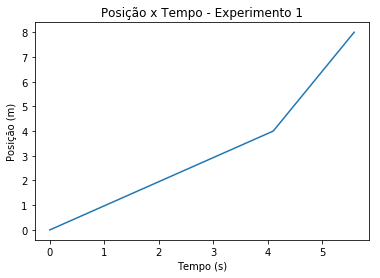

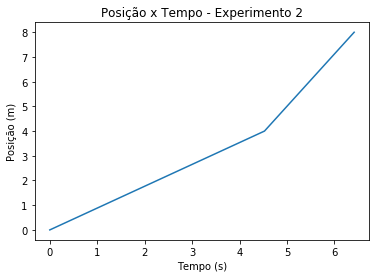

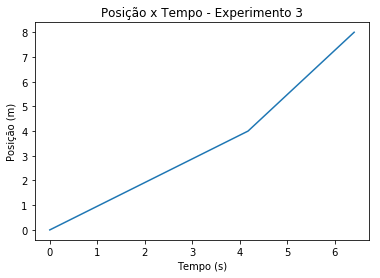

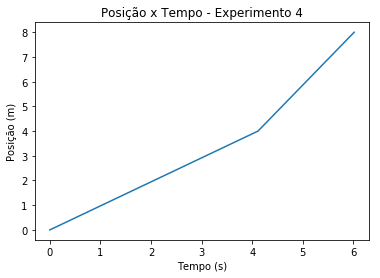

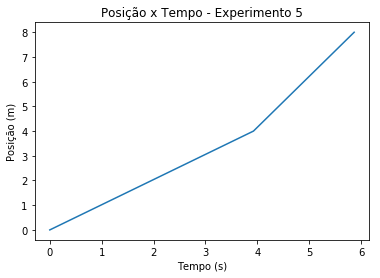

0.551597260969928
-0.42746999618029285
0.04363323129985824


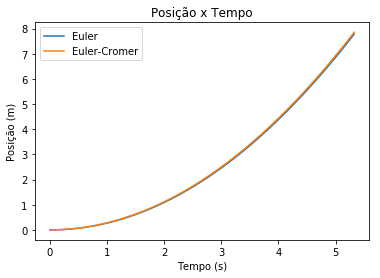

Diferença entre os algoritmos: 0.074m


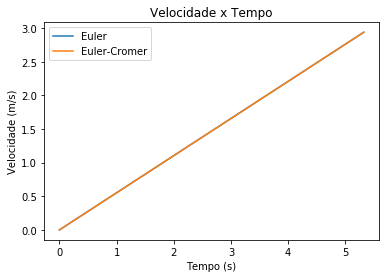

Diferença entre os algoritmos: 0.000m/s


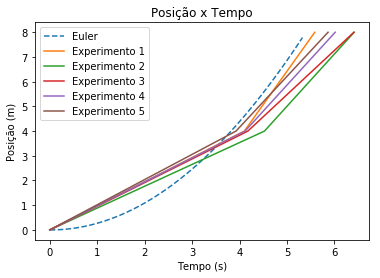

Tempo médio para percorrer 8m experimental: 6.058s
Tempo médio simulado: 5.350s
Erro médio: 0.708s


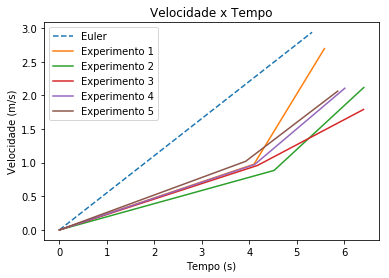

Velocidade média experimental: 1.324m/s
Velocidade média simulada: 1.469m/s
Erro médio: 0.144s


In [7]:
import math
import numpy as np
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as pyplot
import pandas as pd

#Inicializa o vetor de estados
#S = [posição, velocidade, aceleração, tempo]
def initState(x,v,a,t):
    S = [x,v,a,t]
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler
# y = y + v*dt
# v = v + a*dt
# a é constante (g*sin(theta) - atrito*g) = g*(sin(theta)-atrito)
# t = t + dt
def nextState(S,dt):
    S[0] = S[0] + S[1]*dt
    S[1] = S[1] + S[2]*dt
    S[3] = S[3] + dt
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler-Cromer
# v = v + a*dt
# y = y + v*dt
# a é constante (g*sin(theta) - atrito*g) = g*(sin(theta)-atrito)
# t = t + dt
def nextStateCromer(S,dt):
    S[1] = S[1] + S[2]*dt
    S[0] = S[0] + S[1]*dt
    S[3] = S[3] + dt
    return(S)

xs = []
theta = 2.5*math.pi/180 #ângulo de inclinação da rampa: 2.5°
def rampa():
    atrito = 0.1
    
    #Lê e organiza os dados
    data = pd.read_csv('skate_tempos.csv', sep=';', decimal='.')    
    data = data.as_matrix().transpose()
        
    txe = [] #tempos para cruzar 4m e 8m para cada experimento
    vxe = [] #velocidades médias nos intervalos [0,4] e [4,8] para cada experimento
    tme = 0.0 #tempo médio exmperimental (para descer a rampa de 8m)
    vme = 0.0 #velocidade média experimental
    counter = 1
    i = 1
    
    #Plota gráfico de posição x tempo para cada experimento
    while i < 11:
        pyplot.figure()
        pyplot.xlabel("Tempo (s)")
        pyplot.ylabel("Posição (m)")
        pyplot.title("Posição x Tempo - Experimento {}".format(counter))
        t4 = (data[i][0] + data[i+1][0])/2
        t8 = (data[i][1] + data[i+1][1])/2
        v4 = 4/t4
        v8 = 4/(t8-t4)
        txe.append([0,t4,t8])
        vxe.append([0,v4,v8])
        vme += 8/t8
        tme += t8
        pyplot.plot([0,t4,t8],[0,4,8])
        pyplot.show()
        counter+=1
        i+=2
        
    #Médias    
    vme = vme/5
    tme = tme/5
    
    #Simula os experimentos utilizando algoritmo de Euler para sistemas dinâmicos
    
    theta = 2.5*math.pi/180 #ângulo de inclinação da rampa: 2.5°
    g = -9.8 #aceleração da gravidade
    x = 0.0 #onde 0 é o inicio da rampa e 8 o final
    v = 0.0 #sai do repouso
    a = g*(math.sin(theta)-atrito*math.cos(theta)) #rampa
    print(a)
    print(g*math.sin(theta))
    print(theta)
    t = 0.0 #tempo inicial
    dt = 0.025
    
    S = initState(x,v,a,t)
    Sc = initState(x,v,a,t)
    
    #xs = [] #posição simulada por Euler
    vs = [] #velocidade simulada por Euler
    xsc = [] #posição simulada por Euler-Cromer
    vsc = [] #velocidade simulada por Euler-Cromer
    tempo = []
    
    #Faz a simulação até atingir 8m
    while abs(S[0] - 8) > 0.2:
    #for i in range(100):    
        xs.append(S[0])
        vs.append(S[1])
        xsc.append(Sc[0])
        vsc.append(Sc[1])
        tempo.append(S[3])
        nextState(S, dt)
        nextStateCromer(Sc, dt)
    
    #Médias
    tms = S[3] #tempo médio simulado
    vms = S[0]/tms #velocidade média simulado
    
    #Plota o resultado das simulações
    
    pyplot.figure()
    pyplot.plot(tempo, xs, label='Euler')
    pyplot.plot(tempo, xsc, label='Euler-Cromer')
    pyplot.title("Posição x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (m)")
    pyplot.legend()
    pyplot.show()
    
    print("Diferença entre os algoritmos: %.3fm" %(abs(Sc[0]-S[0])))
    
    pyplot.figure()
    pyplot.plot(tempo, vs, label='Euler')
    pyplot.plot(tempo, vsc, label='Euler-Cromer')
    pyplot.title("Velocidade x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Velocidade (m/s)")
    pyplot.legend()
    pyplot.show()
          
    print("Diferença entre os algoritmos: %.3fm/s" %(abs(Sc[1]-S[1])))
    
    #Compara observado e esperado
        
    pyplot.figure()
    pyplot.plot(tempo, xs,linestyle='--',label='Euler')
    for i in range(5):
        pyplot.plot(txe[i],[0,4,8],label='Experimento {}'.format(i+1))
    pyplot.title("Posição x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (m)")
    pyplot.legend()
    pyplot.show()
    
    print("Tempo médio para percorrer 8m experimental: %.3fs" %(tme))
    print("Tempo médio simulado: %.3fs" %(tms))
    print("Erro médio: %.3fs" %(abs(tme-tms)))
        
    pyplot.figure()
    pyplot.plot(tempo, vs,linestyle='--',label='Euler')
    for i in range(5):
        pyplot.plot(txe[i],vxe[i],label='Experimento {}'.format(i+1))
    pyplot.title("Velocidade x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Velocidade (m/s)")
    pyplot.legend()
    pyplot.show()
    
    print("Velocidade média experimental: %.3fm/s" %(vme))
    print("Velocidade média simulada: %.3fm/s" %(vms))
    print("Erro médio: %.3fs" %(abs(vms-vme)))
        
rampa()

skate1


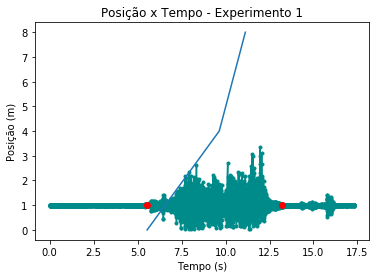

skate2


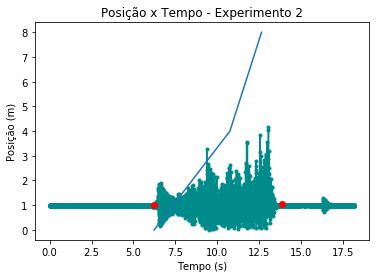

skate3


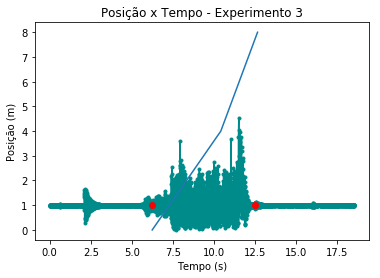

skate4


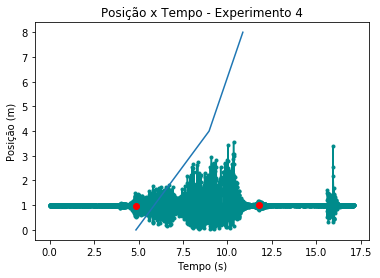

skate5


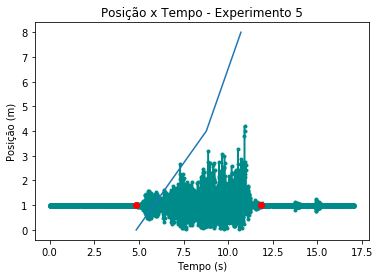

In [8]:
#Lê e organiza os dados
data = pd.read_csv('skate_tempos.csv', sep=';', decimal='.')    
data = data.as_matrix().transpose()

txe = [] #tempos para cruzar 4m e 8m para cada experimento
vxe = [] #velocidades médias nos intervalos [0,4] e [4,8] para cada experimento
tme = 0.0 #tempo médio exmperimental (para descer a rampa de 8m)
vme = 0.0 #velocidade média experimental
counter = 1
i = 1

#Plota gráfico de posição x tempo para cada experimento
while i < 11:
    pyplot.figure()
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (m)")
    pyplot.title("Posição x Tempo - Experimento {}".format(counter))
    t4 = (data[i][0] + data[i+1][0])/2
    t8 = (data[i][1] + data[i+1][1])/2
    v4 = 4/t4
    v8 = 4/(t8-t4)
    txe.append([0,t4,t8])
    vxe.append([0,v4,v8])
    vme += 8/t8
    tme += t8
    filename='skate{}'.format(-(-i//2))
    print(filename)
    begin = acelerometro(filename,5.0,15)
    pyplot.plot([begin,t4+begin,t8+begin],[0,4,8])
    pyplot.show()
    counter+=1
    i+=2    


In [9]:
x = xs
y = 8*math.sin(theta)
width = math.sqrt(8**2 - y**2)
dt = 0.025

pyplot.rcParams["figure.figsize"] = [5,5]
fig = pyplot.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 9), ylim=(0, 3))
ax.grid()

line1, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)
line3, = ax.plot([], [], 'o-', lw=2)
point, = ax.plot([], 'o')
time_template = 'time = %.1fs'
time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes)

def init():
    line1.set_data([0,0], [y,0])
    line2.set_data([width], [0,0])
    line3.set_data([width], [y,0])
    point.set_data([0,y])
    time_text.set_text('')
    return line1, line2, line3, time_text

def animate(i):
    point.set_data([x[i],y+0.05 - x[i]*math.sin(theta)])
    line1.set_data([0,0], [0,y])
    line2.set_data([0,width], [0,0])
    line3.set_data([0,width], [y,0])
    time_text.set_text(time_template % (i*dt))
    return point, line1, line2, line3, time_text

anim = animation.FuncAnimation(fig, animate, np.arange(1, len(x)),
                              interval=10, blit=True, init_func=init)
pyplot.close()

In [10]:
HTML(anim.to_html5_video())

[[8.195 0.68 ]
 [8.2   0.71 ]
 [8.4   0.66 ]
 [8.61  0.75 ]
 [8.66  0.87 ]]


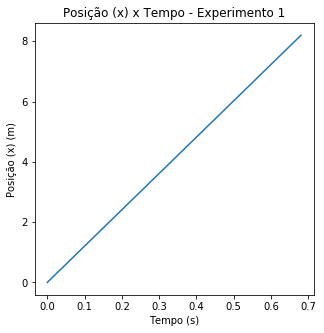

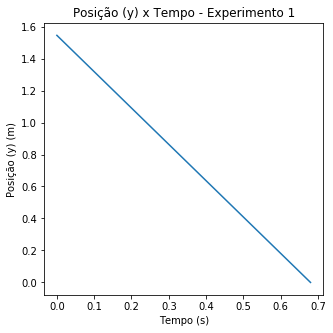

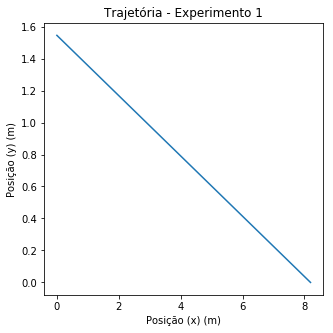

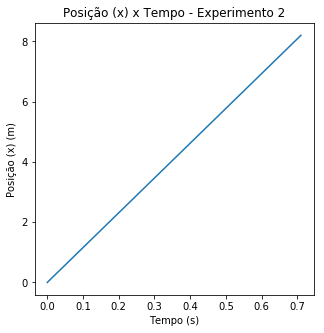

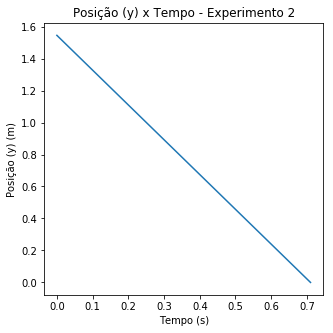

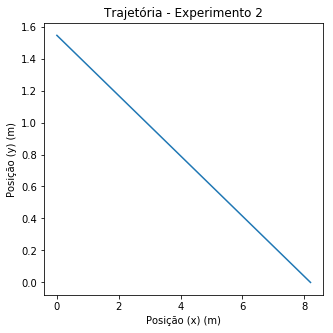

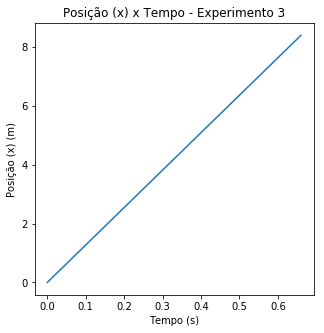

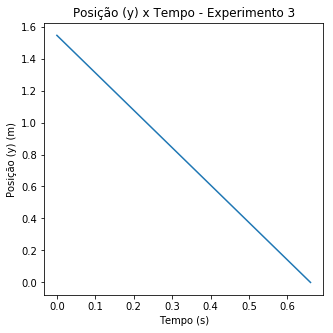

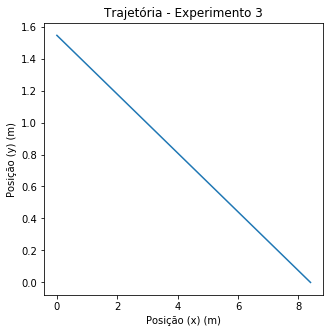

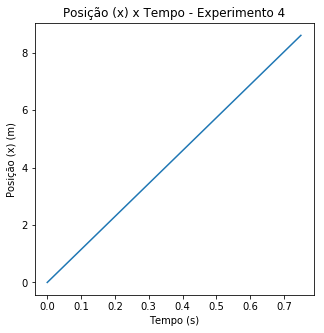

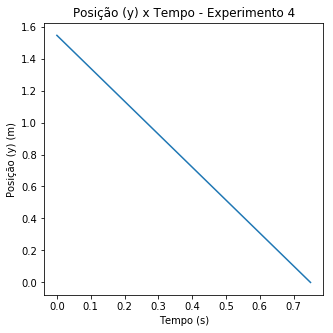

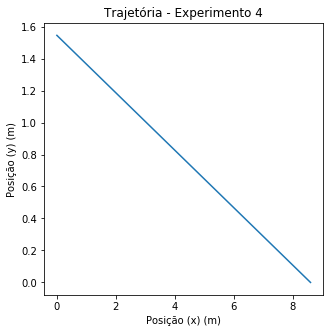

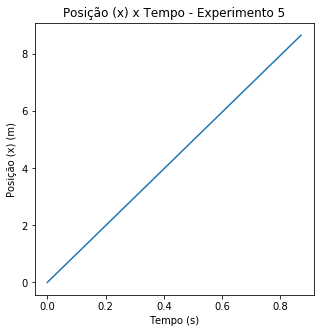

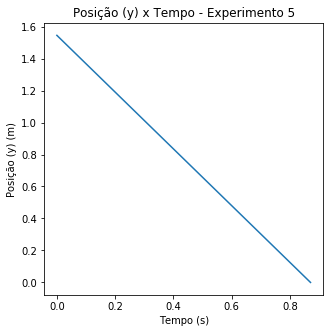

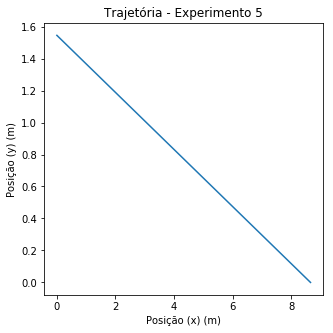

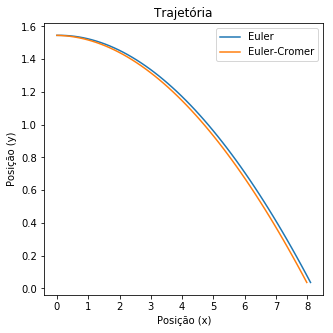

Diferença entre os algoritmos: 0.119m


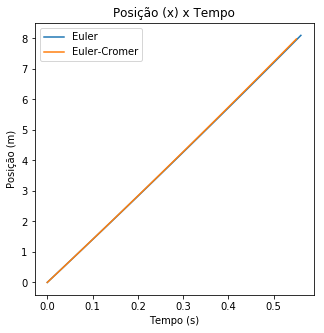

Diferença entre os algoritmos: 0.119m


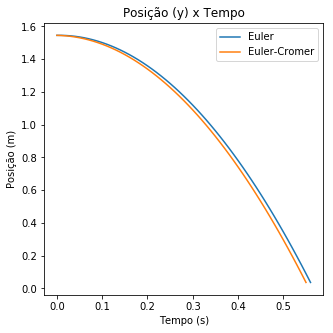

Diferença entre os algoritmos: 0.010s


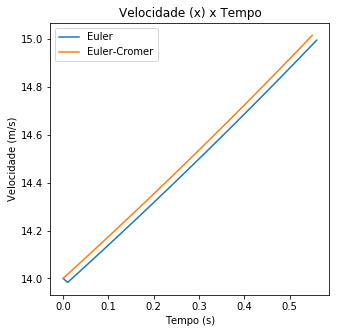

Diferença entre os algoritmos: 0.020m/s


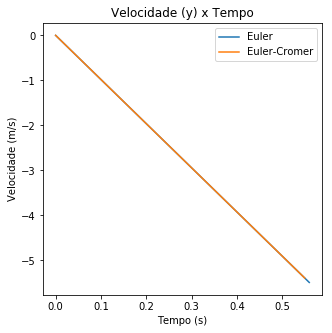

Diferença entre os algoritmos: 0.098m/s


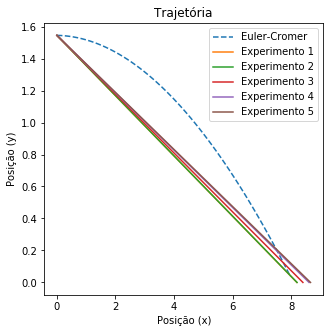

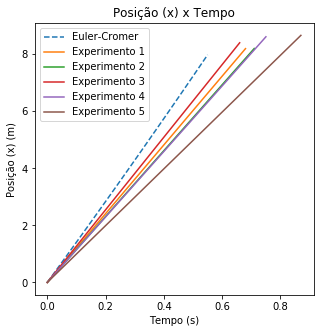

Distância (x) experimental percorrida pela bala: 8.413m
Distância (x) simulada: 8.098m
Erro médio: 0.315m


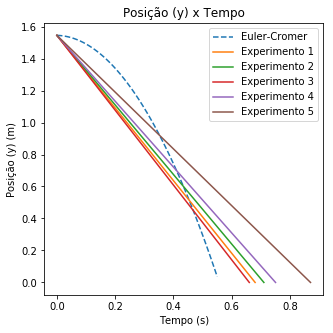

Tempo médio experimental para bala atingir o chão: 0.734s
Tempo simulado: 0.550s
Erro médio: 0.184s


In [11]:
#Inicializa o vetor de estados
#S = [posição(x), posição(y), velocidade(x), velocidade(y), aceleração(x), aceleração(y), tempo]
def initState(x,y,vx,vy,ax,ay,t):
    S = [x,y,vx,vy,ax,ay,t]
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler
# x = x + vx*dt
# y = y + vx*dt
# vx = vx + ax*dt
# vy = vy + ay*dt
# ax = -0.0001*vx (simular resistência do ar)
# ay é constante (g)
# t = t + dt
def nextState(S,m,dt):
    S[0] = S[0] + S[2]*dt
    S[1] = S[1] + S[3]*dt
    S[2] = S[2] + S[4]*dt
    S[3] = S[3] + S[5]*dt
    S[4] = ((0.0129 * 0.295 * 6.66)/2 * S[2]**2)/m
    S[6] = S[6] + dt
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler
# ax = -0.0001*vx (simular resistência do ar)
# vx = vx + ax*dt
# vy = vy + ay*dt
# x = x + vx*dt
# y = y + vx*dt
# ay é constante (g)
# t = t + dt
def nextStateCromer(S,m,dt):
    S[4] = ((0.0129 * 0.295 * 6.66)/2 * S[2]**2)/m
    S[2] = S[2] + S[4]*dt
    S[3] = S[3] + S[5]*dt
    S[0] = S[0] + S[2]*dt
    S[1] = S[1] + S[3]*dt
    S[6] = S[6] + dt
    return(S)

posxc = []
posyc = []
def lancamento():
    m = 1.44 #massa da bala
    
    #Lê e organiza os dados
    data = pd.read_csv('lancamento_tempos.csv', sep='\t', decimal=',')    
    data = data.as_matrix().transpose()

    print(data)
    
    time = []
    posxe = []
    posye = []
    xme = 0.0
    tme = 0.0
    
    #Plota gráfico de posição (x) x tempo para cada experimento
    for i in range(5):
        pyplot.figure()
        pyplot.xlabel("Tempo (s)")
        pyplot.ylabel("Posição (x) (m)")
        pyplot.title("Posição (x) x Tempo - Experimento {}".format(i+1))
        y = 1.545
        x = data[i][0]
        t = data[i][1]
        xme += x
        tme += t
        pyplot.plot([0,t],[0,x])
        time.append([0,t])
        posxe.append([0,x])
        posye.append([1.545,0])
        pyplot.show()
        pyplot.figure()
        pyplot.xlabel("Tempo (s)")
        pyplot.ylabel("Posição (y) (m)")
        pyplot.title("Posição (y) x Tempo - Experimento {}".format(i+1))
        pyplot.plot([0,t],[1.545,0])
        pyplot.show()
        pyplot.figure()
        pyplot.xlabel("Posição (x) (m)")
        pyplot.ylabel("Posição (y) (m)")
        pyplot.title("Trajetória - Experimento {}".format(i+1))
        pyplot.plot([0,x],[1.545,0])
        pyplot.show()
        
    tme = tme/5
    xme = xme/5
        
    #Simula os experimentos utilizando algoritmo de Euler para sistemas dinâmicos
    g = 9.8 #aceleração gravitacional
    x = 0 #posição(x) inicial do projétil
    y = 1.545 #altura inicial do projétil
    vx = 14 #estimativa de velocidade inicial (x) do projétil
    vy = 0.0 #inicialmente, nenhuma força vertical age sobre o projétil
    ax = -((0.0129 * 0.295 * 6.66)/2 * vx**2)/m #resistência do ar
    ay = -g #aceleração causada pela força peso
    t = 0.0 #tempo inicial
    dt = 0.01
    
    S = initState(x,y,vx,vy,ax,ay,t)
    Sc = initState(x,y,vx,vy,ax,ay,t)
    posx = [] #coordenada x do projétil (Euler)
    posy = [] #coordenada y do projétil (Euler)
    velx = [] #velocidade na direção do eixo x (Euler)
    vely = [] #velocidade na direção do eixo y (Euler)
   # posxc = [] #coordenada x do projétil (Euler-Cromer)
   # posyc = [] #coordenada y do projétil (Euler-Cromer)
    velxc = [] #velocidade na direção do eixo x (Euler-Cromer)
    velyc = [] #velocidade na direção do eixo y (Euler-Cromer)
    tempo = []
    tempoc = []
    
    #Faz a simulação até atingir o chão (0m)
    while S[1] > 0 or Sc[1] > 0:
        if (S[1] > 0):
            posx.append(S[0])
            posy.append(S[1])
            velx.append(S[2])
            vely.append(S[3])
            tempo.append(S[6])
            nextState(S, m, dt)
        
        if (Sc[1] > 0):
            posxc.append(Sc[0])
            posyc.append(Sc[1])
            velxc.append(Sc[2])
            velyc.append(Sc[3])
            tempoc.append(Sc[6])
            nextStateCromer(Sc, m, dt)
            
    pyplot.figure()
    pyplot.plot(posx, posy, label='Euler')
    pyplot.plot(posxc, posyc, label='Euler-Cromer')
    pyplot.title("Trajetória")
    pyplot.xlabel("Posição (x)")
    pyplot.ylabel("Posição (y)")
    pyplot.legend()
    pyplot.show()
    
    print("Diferença entre os algoritmos: %.3fm" %(abs(Sc[0]-S[0])))
    
    pyplot.figure()
    pyplot.plot(tempo[:len(posx)], posx, label='Euler')
    pyplot.plot(tempo[:len(posxc)], posxc, label='Euler-Cromer')
    pyplot.title("Posição (x) x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (m)")
    pyplot.legend()
    pyplot.show()
    
    print("Diferença entre os algoritmos: %.3fm" %(abs(Sc[0]-S[0])))
    
    pyplot.figure()
    pyplot.plot(tempo[:len(posy)], posy, label='Euler')
    pyplot.plot(tempo[:len(posyc)], posyc, label='Euler-Cromer')
    pyplot.title("Posição (y) x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (m)")
    pyplot.legend()
    pyplot.show()
    
    print("Diferença entre os algoritmos: %.3fs" %(abs(tempo[len(posy)-1]-tempo[len(posyc)-1])))
    
    pyplot.figure()
    pyplot.plot(tempo[:len(velx)], velx, label='Euler')
    pyplot.plot(tempo[:len(velxc)], velxc, label='Euler-Cromer')
    pyplot.title("Velocidade (x) x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Velocidade (m/s)")
    pyplot.legend()
    pyplot.show()
    
    print("Diferença entre os algoritmos: %.3fm/s" %(abs(Sc[2]-S[2])))
    
    pyplot.figure()
    pyplot.plot(tempo[:len(vely)], vely, label='Euler')
    pyplot.plot(tempo[:len(velyc)], velyc, label='Euler-Cromer')
    pyplot.title("Velocidade (y) x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Velocidade (m/s)")
    pyplot.legend()
    pyplot.show()
    
    print("Diferença entre os algoritmos: %.3fm/s" %(abs(Sc[3]-S[3])))
    
    #Compara observado e esperado
        
    pyplot.figure()
    pyplot.plot(posxc, posyc,linestyle='--',label='Euler-Cromer')
    for i in range(5):
        pyplot.plot(posxe[i],posye[i],label='Experimento {}'.format(i+1))
    pyplot.title("Trajetória")
    pyplot.xlabel("Posição (x)")
    pyplot.ylabel("Posição (y)")
    pyplot.legend()
    pyplot.show()
        
    pyplot.figure()
    pyplot.plot(tempoc[:len(posxc)], posxc,linestyle='--',label='Euler-Cromer')
    for i in range(5):
        pyplot.plot(time[i],posxe[i],label='Experimento {}'.format(i+1))
    pyplot.title("Posição (x) x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (x) (m)")
    pyplot.legend()
    pyplot.show()
    
    print("Distância (x) experimental percorrida pela bala: %.3fm" %(xme))
    print("Distância (x) simulada: %.3fm" %(posx[-1]))
    print("Erro médio: %.3fm" %(abs(posx[-1]-xme)))
    
    pyplot.figure()
    pyplot.plot(tempoc[:len(posyc)], posyc,linestyle='--',label='Euler-Cromer')
    for i in range(5):
        pyplot.plot(time[i],posye[i],label='Experimento {}'.format(i+1))
    pyplot.title("Posição (y) x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (y) (m)")
    pyplot.legend()
    pyplot.show()

    print("Tempo médio experimental para bala atingir o chão: %.3fs" %(tme))
    print("Tempo simulado: %.3fs" %(tempoc[-1]))
    print("Erro médio: %.3fs" %(abs(tme-tempoc[-1])))
    
lancamento()

In [12]:
x = posxc
y = posyc
dt = 0.01

pyplot.rcParams["figure.figsize"] = [5,5]
fig = pyplot.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 9), ylim=(0, 3))
ax.grid()

point, = ax.plot([], 'o',color='green')
line, =ax.plot([],[], 'o', color='lightgray')
time_template = 'time = %.1fs'
time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes)

def init():
    point.set_data([0,0.44])
    time_text.set_text('')
    return point, time_text

def animate(i):
    line.set_data(x[:i],y[:i])
    point.set_data([x[i],y[i]])
    time_text.set_text(time_template % (i*dt))
    return point, line, time_text

anim = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=15, blit=True, init_func=init)
pyplot.close()

In [13]:
HTML(anim.to_html5_video())

# Análise - Lançamento Horizontal 

Podemos ver que as trajetórias e a evolução da posição no decorrer do tempo de todos os 5 experimentos estão muito semelhantes. A diferença de tempo e de espaço percorrido pelos projéteis é mínima. 

Porém, ao comparar com os dados teóricos gerados pelos métodos de Euler e Euler-Cromer, vemos que a trajetória esperada é muito diferente das que conseguimos medir experimentalmente (espera-se uma parábola, porém obtemos retas). Da mesma forma, os gráficos de posição em y pelo tempo diferem da teoria. Isso ocorre, principalmente, porque temos poucas medições de tempo/posição (apenas dois pontos: inicial e final). Não foi possível realizar medidas mais precisas pois é muito difícil determinar a posição em x quando o projétil está em suspensão, além de ser inviável ter muitas marcações em um período muito curto de tempo (uma vez que o trajeto leva menos de 1 segundo). 

Por outro lado, comparando com o gráfico de tempo por posição em x, vemos que os resultados estão razoáveis. As pequenas dissemelhanças entre o esperado e o realizado devem-se a diversos fatores práticos, tais como a resistência do ar real que pode divergir dos cálculos, ou até mesmo a inconsistência da pistola NERF.

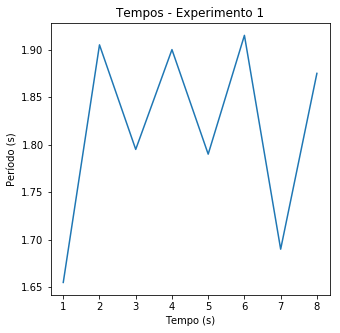

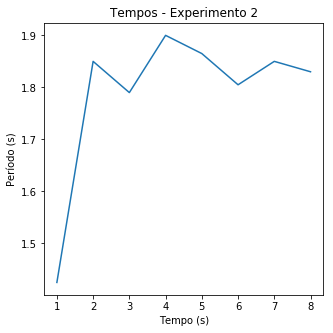

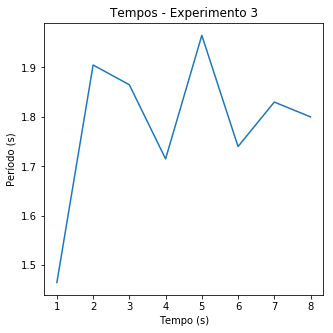

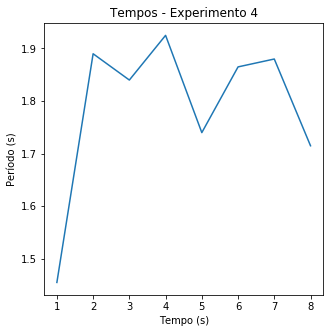

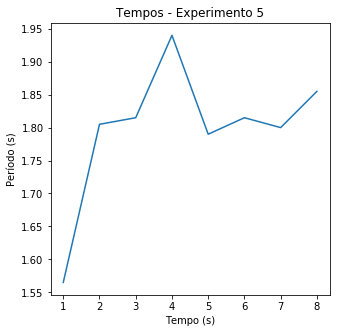

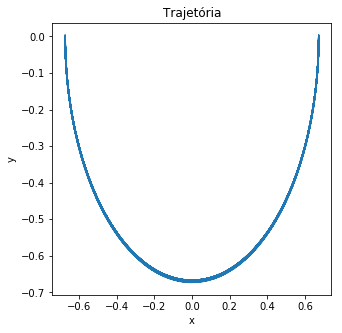

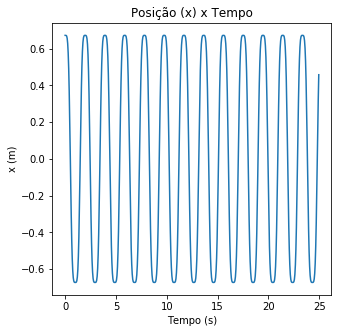

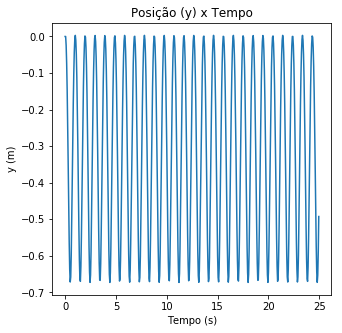

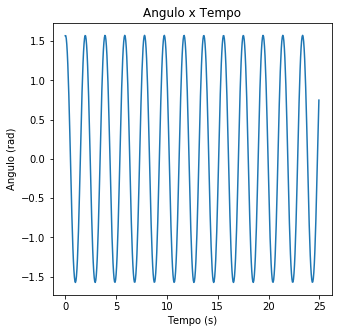

Período esperado: 1.647s
Período obtido (média dos experimentos): 1.795s
Erro: 0.149s


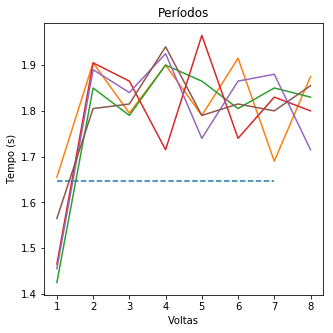

In [14]:
#theta = pi/2
#mLd²theta/dt² = -mgsintheta
#l = 0.673
#v = Ldtheta/dt
#a = Ld²theta/dt²

def initState(theta,dtheta,t):
    #S = np.array([y,v,a,t])
    S = [theta,dtheta,t]
    return(S)

def nextState(S,g,l,dt):
    #Sn = S + dt * rate(S)
    S[0] = S[0] + S[1]*dt
    S[1] = S[1] - (g/l)*math.sin(S[0])*dt
    S[2] = S[2] + dt
    return(S)

def rate(S):
    R = np.array([S[1], S[2], 1, 1])
    return(R)

thetas = []

def pendulo():
    
    data = pd.read_csv('pendulo_tempos.csv', sep=';', decimal='.')        
    data = data.as_matrix().transpose()

    media = 0.0
    per = [[0],[0]*8,[0]*8,[0]*8,[0]*8,[0]*8]
    i = 1
    ctr = 1
    while i < 10:
        pyplot.figure(0)
        pyplot.xlabel("Tempo (s)")
        pyplot.ylabel("Período (s)")
        pyplot.title("Tempos - Experimento {}".format(ctr))
        for j in range(8):
            per[ctr][j] = (data[i][j] + data[i+1][j])/2
            media += per[ctr][j]
        pyplot.plot([1,2,3,4,5,6,7,8],per[ctr])
        pyplot.show()
        i+=2
        ctr+=1
    
    media = media/40
    
    l = 0.673
    g = 9.8
    theta = math.pi/2
    dtheta = 0
    t = 0.0
    dt = 0.05
    
    S = initState(theta,dtheta,t)
    posx = []
    posy = []
    tempo = []
    
    for i in range(500):
        posx.append(math.sin(S[0])*l)
        posy.append(-math.cos(S[0])*l)
        thetas.append(S[0])
        tempo.append(S[2])
        nextState(S,g,l, dt)
        
    pyplot.figure(0)
    pyplot.plot(posx, posy)
    pyplot.title("Trajetória")
    pyplot.xlabel("x")
    pyplot.ylabel("y")
    pyplot.show()
    
    pyplot.figure(0)
    pyplot.plot(tempo, posx)
    pyplot.title("Posição (x) x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("x (m)")
    pyplot.show()
    
    pyplot.figure(0)
    pyplot.plot(tempo, posy)
    pyplot.title("Posição (y) x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("y (m)")
    pyplot.show()
    
    pyplot.figure(0)
    pyplot.plot(tempo, thetas)
    pyplot.title("Angulo x Tempo")
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Angulo (rad)")
    pyplot.show()
    
    T = 2*math.pi*math.sqrt(l/g)
    print("Período esperado: %.3fs" %(T))
    print("Período obtido (média dos experimentos): %.3fs" %(media))
    print("Erro: %.3fs" %(abs(T-media)))

    
    pyplot.figure(0)
    pyplot.plot([1,2,3,4,5,6,7],[T]*7,linestyle='--')
    for i in range(1,6):
        pyplot.plot([1,2,3,4,5,6,7,8],per[i])
    pyplot.title("Períodos")
    pyplot.xlabel("Voltas")
    pyplot.ylabel("Tempo (s)")
    pyplot.show()
    
pendulo()

In [15]:

x = []
y = []
l = 0.673
dt = 0.05

for o in thetas:
    x.append(math.sin(o)*l)
    y.append(-math.cos(o)*l)

pyplot.rcParams["figure.figsize"] = [5,5]
fig = pyplot.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    thisx = [0, x[i]]
    thisy = [0, y[i]]
        
    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

anim = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=50, blit=True, init_func=init)
pyplot.close()

In [16]:
HTML(anim.to_html5_video())

pendulo1


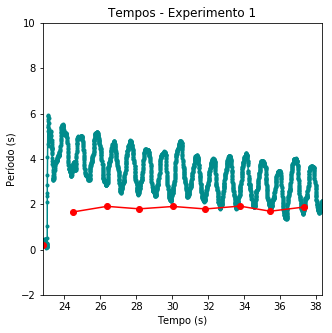

pendulo2


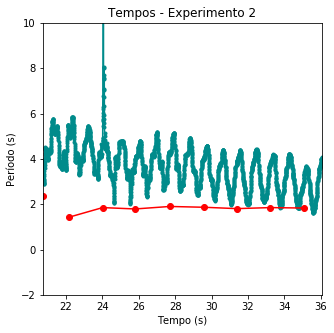

pendulo3


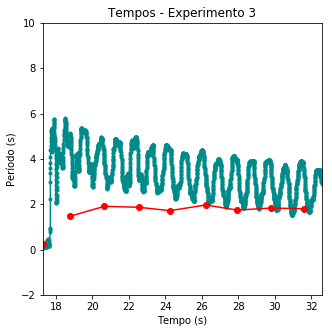

pendulo4


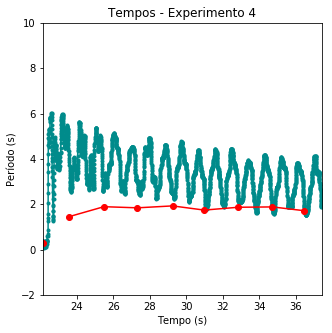

pendulo5


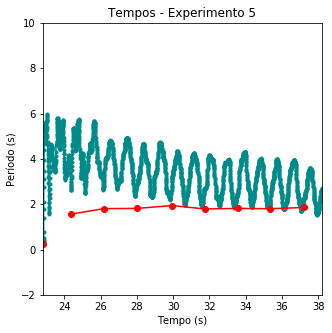

Gráficos completos do acelerômetro para o pêndulo

pendulo1


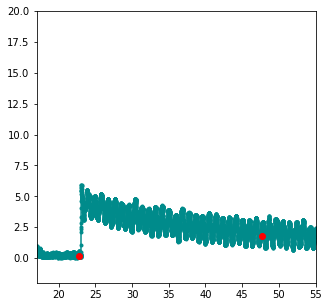

pendulo2


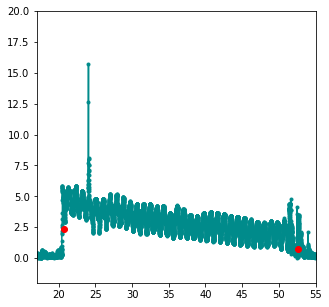

pendulo3


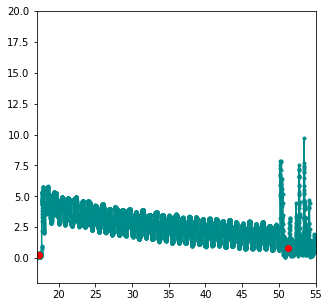

pendulo4


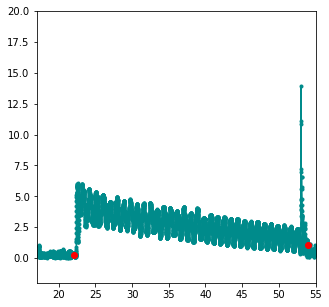

pendulo5


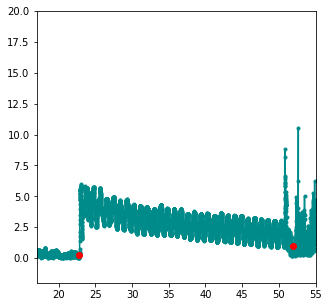

In [17]:
data = pd.read_csv('pendulo_tempos.csv', sep=';', decimal='.')        
data = data.as_matrix().transpose()

media = 0.0
per = [[0],[0]*8,[0]*8,[0]*8,[0]*8,[0]*8]
i = 1
ctr = 1
while i < 10:
    pyplot.figure(0)
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Período (s)")
    pyplot.title("Tempos - Experimento {}".format(ctr))
    for j in range(8):
        per[ctr][j] = (data[i][j] + data[i+1][j])/2
        media += per[ctr][j]
    filename='pendulo{}'.format(ctr)
    print(filename)
    begin = acelerometro(filename,17.0,55)
    pyplot.plot([begin+per[ctr][0],begin+sum(per[ctr][0:2]),begin+sum(per[ctr][0:3]),begin+sum(per[ctr][0:4]),
                 begin+ sum(per[ctr][0:5]),begin+sum(per[ctr][0:6]),begin+sum(per[ctr][0:7]),begin+sum(per[ctr][0:8])]
                ,per[ctr],'-o',color='red')
    pyplot.axis([begin,begin+sum(per[ctr][0:8])+1,-2,10])
    pyplot.show()
    i+=2
    ctr+=1

print("Gráficos completos do acelerômetro para o pêndulo")
print("")
for i in range(1,6):
    filename='pendulo{}'.format(i)
    print(filename)
    acelerometro(filename,17.0,55,20,True)

## Considerações Finais



## Log

O tempo que utilizamos para concluir esse exercício programa foi aproximadamente x horas, sendo:
<ul>
    <li>5h para a realização dos experimentos</li>
    <li>8h para a escrita do código</li>
    <li>xh para a escrita do relatório</li>
    <li>4h para a edição do vídeo</li>
</ul>

## Vídeo do experimento

https://www.youtube.com/watch?v=X82ofFaULzg

## Contribuições dos autores

Eduardo Nascimento foi responsável por (...)

Gabriel Massukado foi responsável por (...)

Larissa Goto foi responsável por (...)

Nathalia Borin foi responsável por (...)

Matheus Lima foi responsável por (...)

Todos os autores escreveram e revisaram esse artigo. Todos os autores leram e aprovaram a versão final desse artigo.